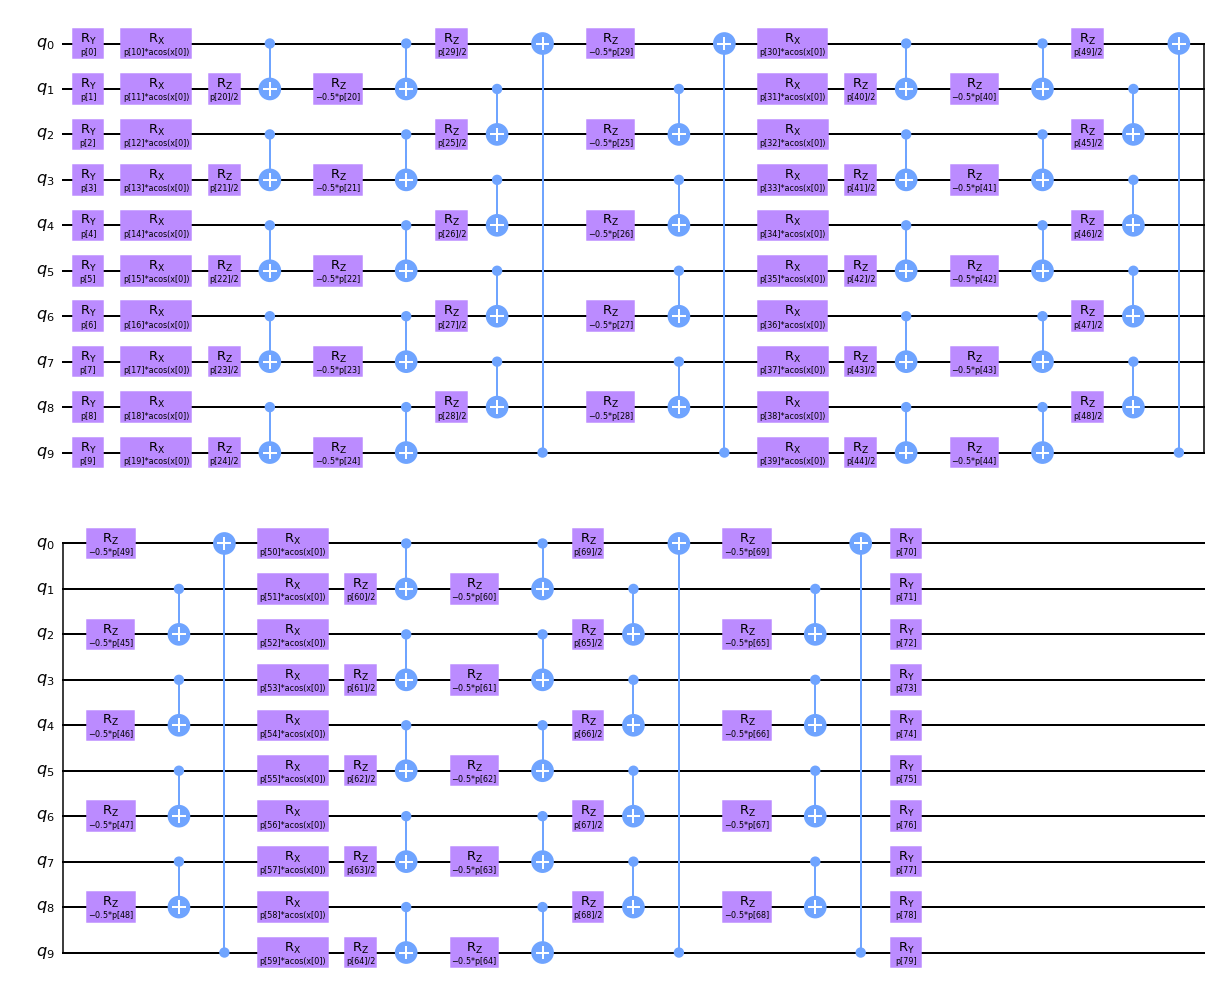

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector,ParameterExpression
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile


from squlearn.feature_map import ChebPQC
from squlearn.expectation_operator import SinglePauli
from squlearn.qnn.qnn import QNN
from squlearn.util import Executor

import copy

from circuit_tree import *

pqc = ChebPQC(10,1,3)

x = ParameterVector("x",pqc.num_features)
p = ParameterVector("p",pqc.num_parameters)

QC = pqc.get_circuit(x,p)



SUPPORTED_GATES = {"x", "y", "z", "h", "rx", "ry", "rz", "p", "u", "cx", "cy", "cz"} #rzz,ryy,rxx also work!
QC = transpile(QC,basis_gates=SUPPORTED_GATES)
QC.draw()

In [2]:
d = circuit_derivative(OpTreeLeafCircuit(QC),p)

In [3]:
grad = simplify_copy(d)
#grad = d

In [4]:
len(str(grad))

2021360

In [5]:
xval = [0.5]
np.random.seed(0)
pval = np.random.rand(pqc.num_parameters)
dictionary = dict(zip(p, pval))
dictionary.update(dict(zip(x, xval)))


In [6]:
from pympler import asizeof
circ = get_first_circuit(grad)
full_size = asizeof.asizeof(circ)
print(f"Size of circuit: {full_size} bytes")


NameError: name 'get_first_circuit' is not defined

In [7]:
evaluate(grad,Estimator(),SparsePauliOp("IIIIIIIIIZ"),dictionary,detect_circuit_duplicates=False)

build_lists_and_index_tree 0.08800101280212402
len(circuit_list) 220
run 0.24500679969787598
res2 2.9310708045959473
result time 0.0
result [-0.63208757  0.57086136 -0.45377712 -0.39562237 -0.39698195 -0.41337345
 -0.41789784 -0.41756223 -0.41745317 -0.41745317 -0.41745317 -0.41745317
 -0.41745317 -0.41745317 -0.41765474 -0.41743165 -0.41646981 -0.41744762
 -0.44435094 -0.41970483 -0.76510667 -0.04206239 -0.50741026 -0.36454805
 -0.39505481 -0.4155362  -0.41813341 -0.41732666 -0.41745317 -0.41745317
 -0.41745317 -0.41745317 -0.41745317 -0.41745317 -0.41765032 -0.41743607
 -0.41587865 -0.41824766 -0.56069043 -0.30783644 -0.34186982 -0.41682001
 -0.23600676  0.5764112  -0.41745317 -0.41745317 -0.41869785 -0.41784306
 -0.41745317 -0.41745317 -0.41745317 -0.41745317 -0.41745317 -0.41745317
 -0.41745317 -0.41745317 -0.3429645  -0.38600771 -0.35977941 -0.36889121
 -0.41951473 -0.41702618 -0.35941174 -0.39792046 -0.41745317 -0.41745317
 -0.41745317 -0.41745317 -0.41745317 -0.41745317 -0.41745

array([-6.01474465e-01, -2.90773752e-02,  8.19575146e-03, -1.67802324e-04,
        2.77555756e-17,  8.32667268e-17,  0.00000000e+00, -1.11547147e-04,
        4.88902650e-04, -1.23230542e-02, -3.78585099e-01, -7.48024760e-02,
        1.07240333e-02, -4.22414469e-04,  5.55111512e-17, -5.55111512e-17,
       -8.32667268e-17, -1.12179536e-04,  1.24040828e-03, -1.32394043e-01,
        2.21842039e-01,  2.13695527e-04,  0.00000000e+00, -9.71445147e-17,
        8.48285300e-03, -1.02493197e-02, -8.32667268e-17,  0.00000000e+00,
       -2.63776599e-04,  1.33895634e-02, -6.04466595e-01, -1.20992713e-01,
        2.72009421e-03, -5.55111512e-17, -2.77555756e-17,  2.49800181e-16,
       -2.49800181e-16, -2.77555756e-17,  4.94279346e-04, -1.12480391e-01,
        1.77294613e-01, -5.55111512e-17, -5.55111512e-17, -4.16333634e-17,
        2.94585252e-03,  1.64047653e-03,  0.00000000e+00,  5.55111512e-17,
       -2.77555756e-17, -1.20056754e-01, -4.81704160e-01, -4.89092919e-02,
        1.11022302e-16,  

In [ ]:
circ = get_first_circuit(grad)
from qiskit.primitives.utils import _circuit_key
hash(_circuit_key(circ))